In [1]:
import os
from os.path import join as opj
from glob import glob as glob
import pandas as pd
import numpy as np


In [2]:
main_dir = "/Users/andrebeukers/Documents/fMRI/RVstudy/visser_replicate"
ratings_dir = opj(main_dir, "ratings")
rating_fpaths = glob(opj(ratings_dir,"*scan_ball_ratings*.csv"))[:-2]
print(rating_fpaths[:5])

['/Users/andrebeukers/Documents/fMRI/RVstudy/visser_replicate/ratings/10_scan_ball_ratings_2016_Apr_19_0828.csv', '/Users/andrebeukers/Documents/fMRI/RVstudy/visser_replicate/ratings/10_scan_ball_ratings_2016_Apr_25_1241.csv', '/Users/andrebeukers/Documents/fMRI/RVstudy/visser_replicate/ratings/10_scan_ball_ratings_2016_Apr_25_1432.csv', '/Users/andrebeukers/Documents/fMRI/RVstudy/visser_replicate/ratings/10_scan_ball_ratings_2016_Apr_25_1454.csv', '/Users/andrebeukers/Documents/fMRI/RVstudy/visser_replicate/ratings/10_scan_ball_ratings_2016_Apr_25_1455.csv']


## parse path to rating files

In [3]:

def parse_rating(path):
    fname_list = os.path.split(path)[-1].split('_')
    sub = fname_list[0]
    tstamp = fname_list[-1].split('.')[0]
    D = {'sub':int(sub),'tstamp':(tstamp),'path':path}
    return D

rating_fpath = rating_fpaths[0]
print(parse_rating(rating_fpath))



{'tstamp': '0828', 'sub': 10, 'path': '/Users/andrebeukers/Documents/fMRI/RVstudy/visser_replicate/ratings/10_scan_ball_ratings_2016_Apr_19_0828.csv'}


## reads single scanball file, returns sub_df

In [4]:
def read_scanball(path):
    # full exel file
    scanball_df = pd.read_csv(path)
    # first col
    stim_name = scanball_df['face'].str.split('\\').str.get(-1).str.split('.').str.get(0)
    # ratings
    rate = scanball_df[['rating.response','rating_2.response']]
    rate = rate.dropna(0)
    # modify cols and index
    rate.columns = ['trust','like']
    rate.index = stim_name.iloc[1:]
    return rate


rating_fpath = rating_fpaths[0]
sub_df = read_scanball(rating_fpath)

print(sub_df.index)



Index(['M51', 'F3', 'M49', 'F1', 'M22', 'F6'], dtype='object', name='face')


## finding CS+ stim

In [5]:
rawonsets_dir = opj(main_dir,'rawonsets')
pain_fpaths = glob(opj(rawonsets_dir,"*pain_final*.csv"))

In [6]:
def parse_rawonsets(path):
    L = os.path.split(path)[-1].split('_')
    sub = int(L[0])
    return sub

pain_fpath = pain_fpaths[0]
print(parse_rawonsets(pain_fpath))

10


In [7]:
def get_subCS(path):
    rawonsets = pd.read_csv(path)
    
    # CS +
    CSplus_idx = rawonsets.loc[:,'inten'] > 0
    CSplus_stim = rawonsets[CSplus_idx].loc[:,'face'
        ].str.split('\\').str.get(-1).str.split('.').str.get(0).unique()
    # CS - 
    CSminus_idx = rawonsets.loc[:,'inten'] == 0
    CSminus_stim = rawonsets[CSminus_idx].loc[:,'face'
        ].str.split('\\').str.get(-1).str.split('.').str.get(0).unique()
    
    sub_CSdict = {'CSp':CSplus_stim, 'CSm':CSminus_stim}
    return sub_CSdict

pain_fpath = pain_fpaths[0]
sub_CSdict = get_subCS(pain_fpath)
print(sub_CSdict)


{'CSm': array(['M51'], dtype=object), 'CSp': array(['M22', 'M49'], dtype=object)}


## loop, sub:CS+ dict

In [8]:
group_CSdict = dict()
CS_prob = list()

for pain_fpath in pain_fpaths:
    sub = parse_rawonsets(pain_fpath)
    
    try:
        # get subCS dict
        sub_CSdict = get_subCS(pain_fpath)
        # load dict
        group_CSdict[sub] = sub_CSdict
        
    except:
        CS_prob.append(sub)
        
            
print(group_CSdict)

{4: {'CSm': array(['M51'], dtype=object), 'CSp': array(['M49', 'M22'], dtype=object)}, 6: {'CSm': array(['M51'], dtype=object), 'CSp': array(['M22', 'M49'], dtype=object)}, 7: {'CSm': array(['M22'], dtype=object), 'CSp': array(['M49', 'M51'], dtype=object)}, 335: {'CSm': array(['M51'], dtype=object), 'CSp': array(['M22', 'M49'], dtype=object)}, 9: {'CSm': array(['M49'], dtype=object), 'CSp': array(['M22', 'M51'], dtype=object)}, 10: {'CSm': array(['M51'], dtype=object), 'CSp': array(['M22', 'M49'], dtype=object)}, 11: {'CSm': array(['M22'], dtype=object), 'CSp': array(['M51', 'M49'], dtype=object)}, 12: {'CSm': array(['M22'], dtype=object), 'CSp': array(['M51', 'M49'], dtype=object)}, 13: {'CSm': array(['M51'], dtype=object), 'CSp': array(['M22', 'M49'], dtype=object)}, 14: {'CSm': array(['M49'], dtype=object), 'CSp': array(['M51', 'M22'], dtype=object)}, 15: {'CSm': array(['M49'], dtype=object), 'CSp': array(['M22', 'M51'], dtype=object)}, 16: {'CSm': array(['M49'], dtype=object), 'CS

# Full behavioural dataset, multi-indexing df


## initialize data frames

In [44]:
rating_prob = list()

subs = [parse_rating(rating_fpath)['sub'] 
        for rating_fpath in rating_fpaths]

index = pd.MultiIndex(names=['sub','tstamp','stim','CSp'],
            levels=[[],[],[],[]], labels=[[],[],[],[]])

group_df = pd.DataFrame(index=index, 
            columns=['like','trust','CSp'])


# group_df.loc[(1,10,'F1','1'),'CSp']=10
group_df


,,,,like,trust,CSp
sub,tstamp,stim,CSp,,,


## loop: load group df

In [45]:
for rating_fpath in rating_fpaths:
    
    try:
        # load data frame
        sub_df = read_scanball(rating_fpath)
        
        # get subject number, time stamp and CSp_dict
        D = parse_rating(rating_fpath)
        sub, tstamp = D['sub'], D['tstamp']
        sub_CSdict = group_CSdict[sub] 
        
        # load subject dataframe into group
        for stim in sub_df.index:
            
            # sorting CSp and CSm
            if stim in sub_CSdict['CSm']: CSp = 0
            elif stim in sub_CSdict['CSp'][0]: CSp = 1
            elif stim in sub_CSdict['CSp'][1]: CSp = 2
            else: CSp = 100
            
            # each column
            for lt in ['like','trust']: 
                group_df.loc[(sub,tstamp,stim,CSp),lt] =\
                              sub_df.loc[stim][lt]

            # also include CSp in cols for logical indexing
            group_df.loc[(sub,tstamp,stim,CSp),'CSp'] = CSp
            
        
                 
    except:
        rating_prob.append(parse_rating(rating_fpath)['sub'])

# remove brush trials (female faces)
group_df = group_df[group_df['CSp'] != 100][['like','trust']]





In [128]:
group_df[:20]

like trust
sub tstamp stim CSp           
10  0828   M51  0     40    30
           M49  2     50    50
           M22  1     61    61
    1241   M49  2     49    53
           M22  1     39    38
           M51  0     40    32
    1432   M49  2     34    36
           M51  0     58    47
           M22  1     33    42
    1455   M22  1     36    26
           M51  0     56    42
           M49  2     43    37
11  0821   M51  1     66    62
           M49  2     52    80
           M22  0     51    36
    0951   M22  0     33    33
           M51  1     67    39
           M49  2     67    67
    1012   M22  0     40    32
           M49  2     52    65

# Plotting

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

### Need tstamp on the x-axis, like on the y-axis, (different lines for cm,cp1,cp2 and different plots for each sub)

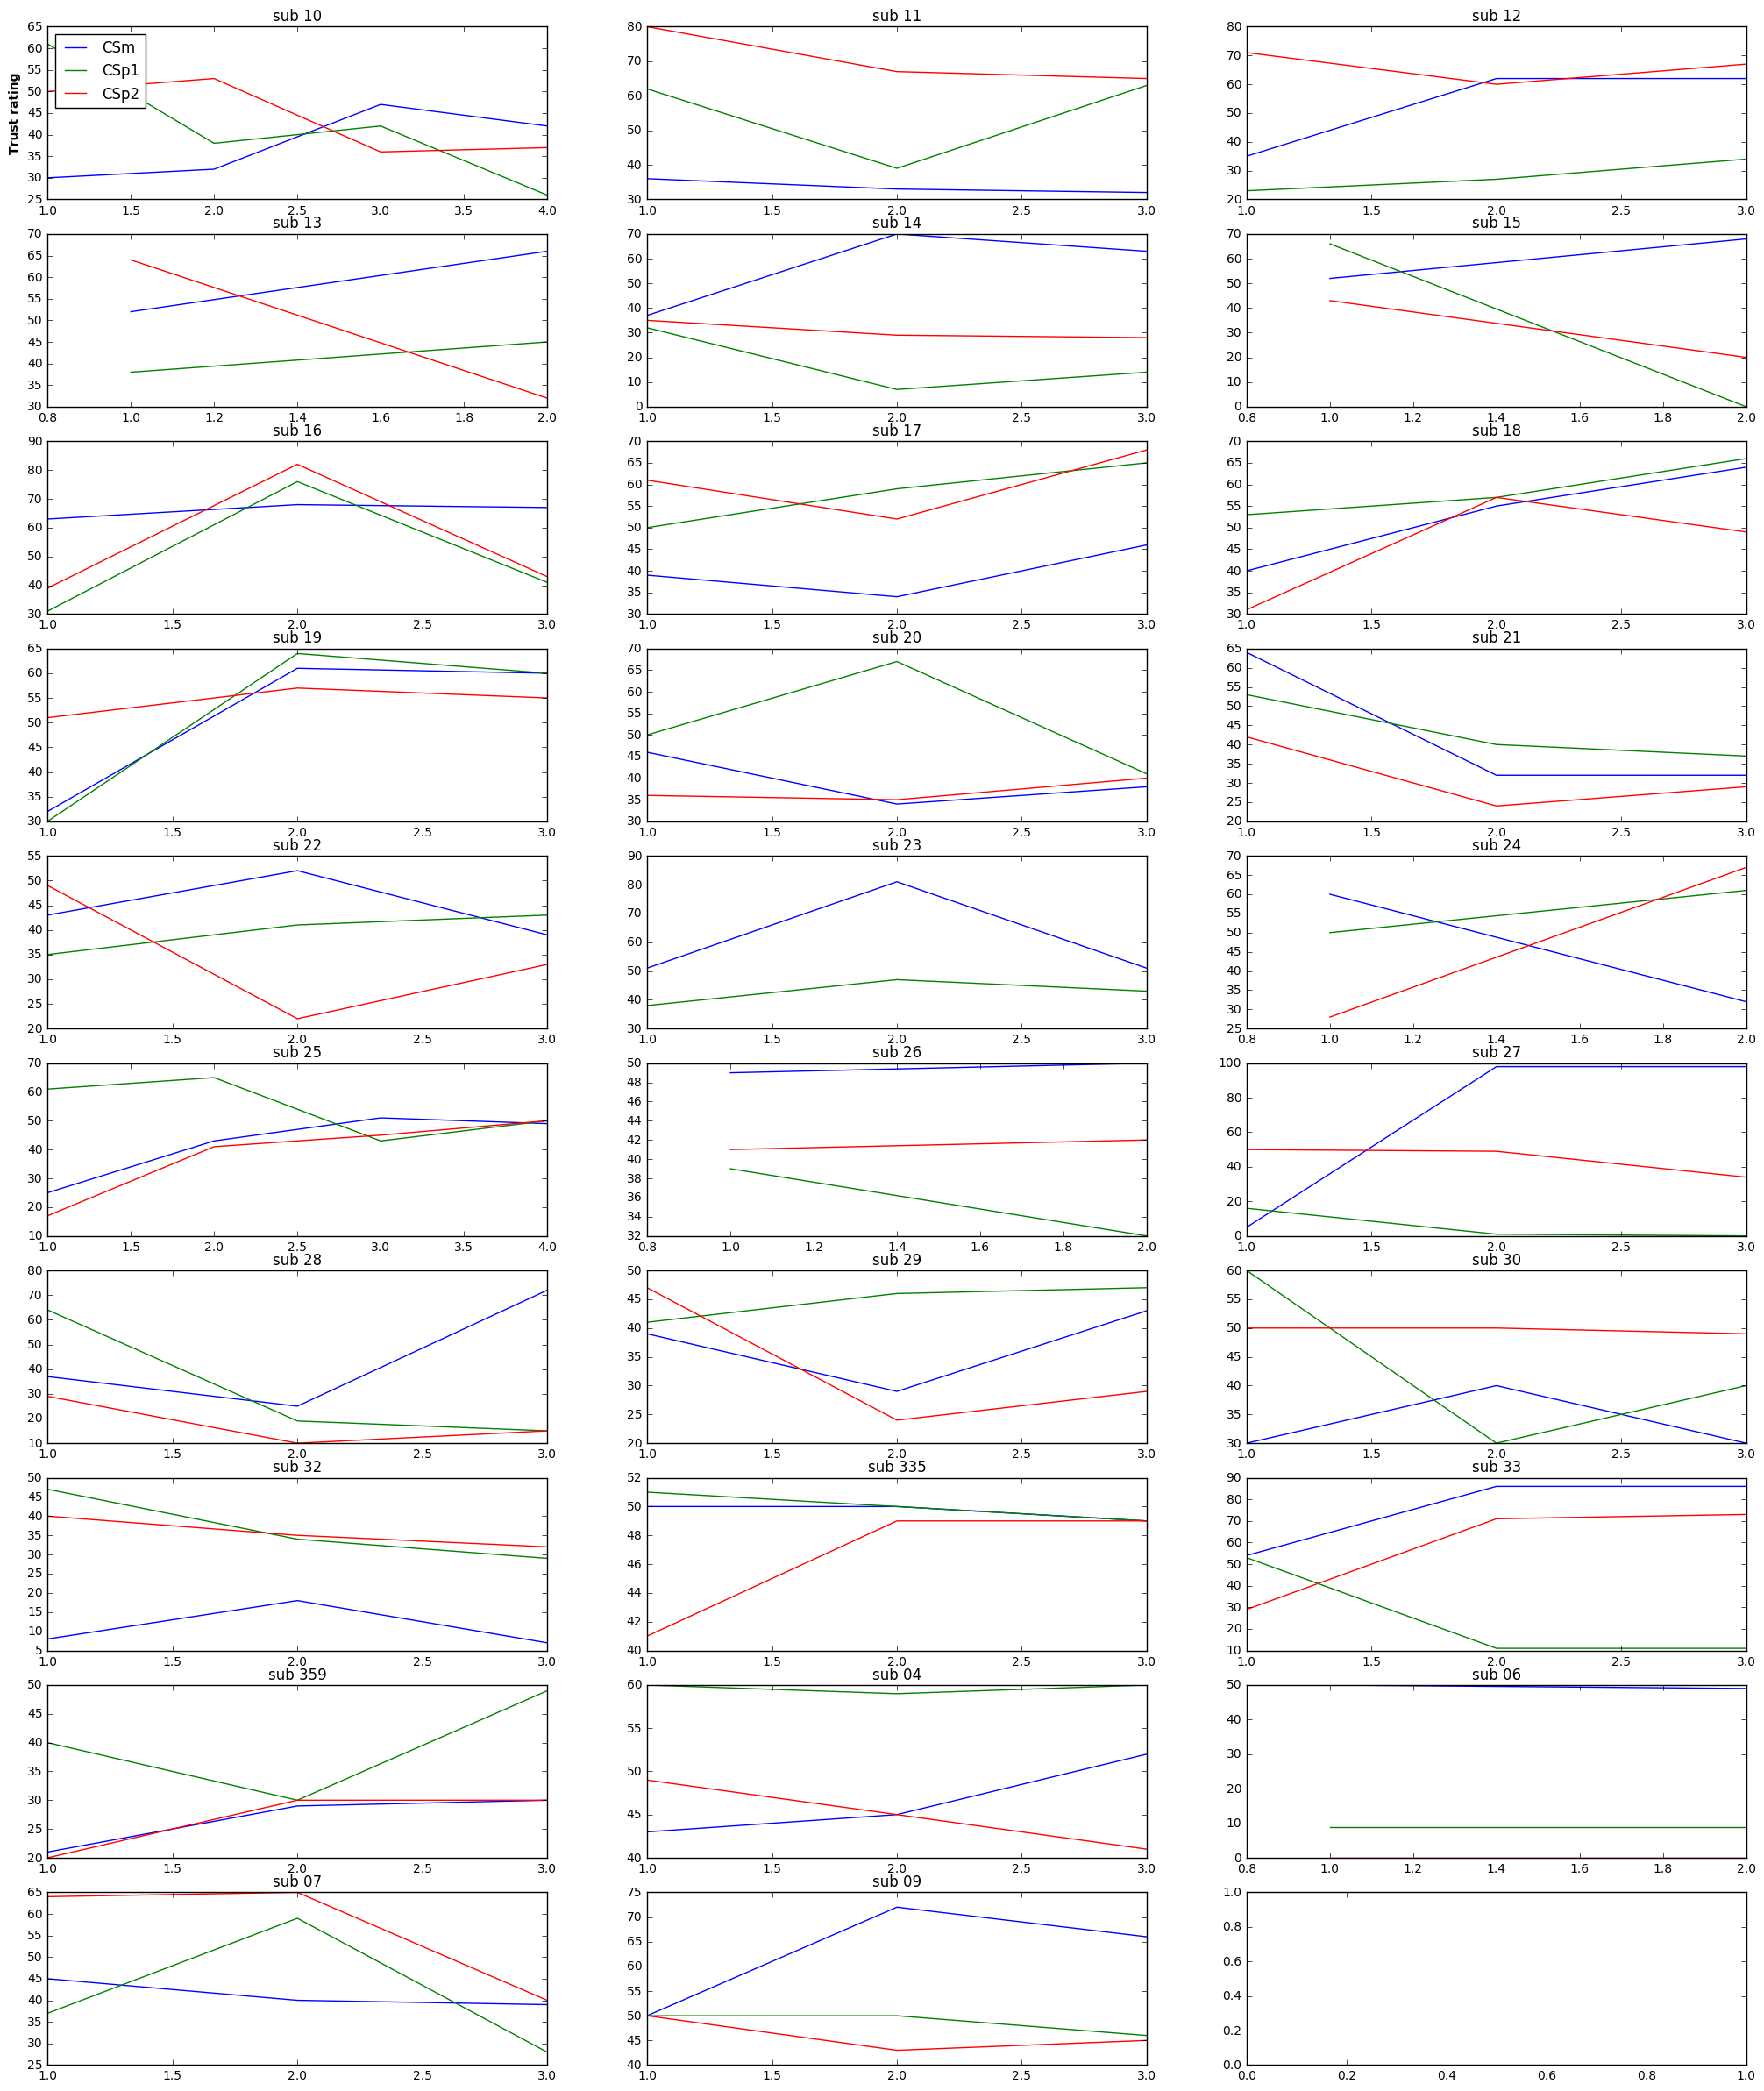

In [285]:
sub_list = group_df.index.levels[0]
n = len(sub_list)
lt = 'trust'

fig, axes = plt.subplots(nrows=round(n/3), ncols=3, figsize=(25,30))
axes = axes.reshape(-1)

i = -1
for sub_num in sub_list:
    i+=1
    
    for CSp in [0,1,2]:
        y = group_df.xs((sub_num,CSp),level=('sub','CSp'))[lt]
        x = np.arange(len(y)+1)[1:]
        
        try: axes[i].plot(x, y.values)
        except: pass
    
    axes[i].set_title('sub %.2i' % sub_num)


axes[0].legend(['CSm','CSp1','CSp2'], loc='upper left')
axes[0].set_ylabel("%s rating" % lt.capitalize(), fontweight='bold')

